# Image Captioning with Multi-Modal Attention 

This project focuses on developing an image captioning model that integrates both visual and textual data using a multi-modal attention mechanism. I utilized InceptionV3 architecture for image feature extraction and a stack of Bidirectional LSTM layers for processing text captions. A multi-head attention layer combines these features to generate contextually relevant captions for given images.




In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings("ignore")


### Filtering DataFrame for Short Comments

Data is filtered to include rows where the column 'comment_number' equals 3 or 4. This selection is based on the oberservation that these comments are shorter versions than 0,1,2


In [2]:
df = pd.read_csv('../data/flickr30k_images/results.csv', delimiter='|')
df = df[(df[' comment_number']==3) | (df[' comment_number']==4)]

df

image_name   comment_number  \
3       1000092795.jpg                3   
4       1000092795.jpg                4   
8         10002456.jpg                3   
9         10002456.jpg                4   
13      1000268201.jpg                3   
...                ...              ...   
158904   997876722.jpg                4   
158908    99804383.jpg                3   
158909    99804383.jpg                4   
158913   998845445.jpg                3   
158914   998845445.jpg                4   

                                                  comment  
3            A man in a blue shirt standing in a garden .  
4                 Two friends enjoy time spent together .  
8                   Four men on top of a tall structure .  
9                              Three men on a large rig .  
13        A little girl climbing into a wooden playhouse   
...                                                   ...  
158904           Fruits stationed by a dusty old window .  
158908   An elderly man sits outside a storefront acco...  
158909   An elderly gentleman playing a musical instru...  
158913   A man riding a small boat in a harbor , with ...  
158914   A man on a moored blue and white boat with hi...  

[63566 rows x 3 columns]

In [3]:
df.columns=['image_name', 'comment_number', 'comment']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63566 entries, 3 to 158914
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_name      63566 non-null  object
 1   comment_number  63566 non-null  int64 
 2   comment         63566 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.9+ MB


In [5]:
image_count = len(df.image_name.unique())
image_count

31783

### Calculating Training Set Size and Split Index

Determine the training set size and split index for images with 2 captions each:

- `train_set_size`: Proportion of the total image count designated for the training set, set to 0.9 (90%).
- `train_image_count`: This is calculated as the integer part of `image_count` multiplied by `train_set_size`, indicating the number of images allocated to the training set.
- `train_split_index`: Given that each image has 2 captions, this index marks the boundary within the dataset where the training set ends, computed by multiplying `train_image_count` by 2.


In [6]:
train_set_size = 0.9
train_image_count = int(image_count*train_set_size)
train_split_index = train_image_count * 2
train_image_count, train_split_index

(28604, 57208)

In [7]:
train_df = df[:train_split_index]
test_df = df[train_split_index:]
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

### Creating Paths for Training and Validation Images

- `img_loc`: Base directory where the images are located (`'/flickr30k_images/images/'`).
- `train_image_paths`: Paths for training images are generated by concatenating `img_loc` with each image name in `train_df.image_name` using the `.values` attribute. The first two paths in the training set are displayed.
- `val_image_paths`: Paths for validation images are similarly constructed using `test_df.image_name` from `img_loc`, and the first two paths in the validation set are displayed.


In [8]:
img_loc = '/Users/sanjeev/Official/Projects/ImageCaptioning/data/flickr30k_images/images/'
train_image_paths = img_loc+train_df.image_name
train_image_paths = train_image_paths.values

val_image_paths = img_loc+test_df.image_name
val_image_paths = val_image_paths.values

train_image_paths[:2], val_image_paths[:2]

(array(['/Users/sanjeev/Official/Projects/ImageCaptioning/data/flickr30k_images/images/1000092795.jpg',
        '/Users/sanjeev/Official/Projects/ImageCaptioning/data/flickr30k_images/images/1000092795.jpg'],
       dtype=object),
 array(['/Users/sanjeev/Official/Projects/ImageCaptioning/data/flickr30k_images/images/6337872636.jpg',
        '/Users/sanjeev/Official/Projects/ImageCaptioning/data/flickr30k_images/images/6337872636.jpg'],
       dtype=object))

### Sentence Preprocessing Function

`preprocess` function performs text preprocessing on a given sentence:

- `sentence`: Input text to be processed.

Steps:
1. Convert the sentence to lowercase.
2. Remove any characters that are not letters, digits, commas, single quotes, or spaces using regular expression substitution.
3. Return the processed sentence.



In [9]:
import re
def preprocess(sentence):
    try:
        sentence = sentence.lower()
        sentence = re.sub(r"[^a-zA-Z0-9, ']", ' ', sentence)
        return sentence
    except Exception as e:
        print(sentence, e)
        raise(e)

### Preprocessing Image Captions

Preprocess image captions for both training and validation datasets:

- Each caption in `train_df.comment` and `test_df.comment` is prefixed with `'startseq '` and suffixed with `' endsq'`.
- `preprocess` function is applied to each caption using a lambda function.


In [10]:
train_texts = 'startseq '+ train_df.comment + ' endsq'
val_texts = 'startseq '+ test_df.comment + ' endsq'

train_texts = train_texts.apply(lambda x: preprocess(str(x)))
val_texts = train_texts.apply(lambda x: preprocess(str(x)))
train_texts[:5], val_texts[:5]


(3     startseq  a man in a blue shirt standing in a ...
 4     startseq  two friends enjoy time spent togethe...
 8     startseq  four men on top of a tall structure ...
 9            startseq  three men on a large rig   endsq
 13    startseq  a little girl climbing into a wooden...
 Name: comment, dtype: object,
 3     startseq  a man in a blue shirt standing in a ...
 4     startseq  two friends enjoy time spent togethe...
 8     startseq  four men on top of a tall structure ...
 9            startseq  three men on a large rig   endsq
 13    startseq  a little girl climbing into a wooden...
 Name: comment, dtype: object)

### Tokenization for Vocabulary Size Determination

Tokenization using the `Tokenizer` class is performed on the `train_texts` to build a vocabulary:

- `fit_on_texts(train_texts)` processes the training texts to generate a vocabulary based on unique words.
- `vocab_size` is calculated as the total number of unique words in the tokenizer's word index plus one, accounting for the index starting from 1 (to include the padding token).



In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)
vocab_size = len(tokenizer.word_index)+1
vocab_size

10624

Training and validation captions are converted into sequences of integers using the fitted `Tokenizer` instance. This transformation maps each word in the captions to its respective index in the tokenizer's word index.


In [12]:
train_labels = tokenizer.texts_to_sequences(train_texts)
val_labels = tokenizer.texts_to_sequences(val_texts)

train_labels[:2], val_labels[:2]

([[2, 1, 6, 4, 1, 37, 30, 33, 4, 1, 659, 3],
  [2, 10, 348, 660, 540, 6714, 115, 3]],
 [[2, 1, 6, 4, 1, 37, 30, 33, 4, 1, 659, 3],
  [2, 10, 348, 660, 540, 6714, 115, 3]])

## Image Preprocessing

- Reads the image file from `file_path` and decodes into 3 channels(RGB) using TensorFlow's `tf.image.decode_image`
- Resizes the image to dimensions (299, 299), to match with Inception model's input size.
- Converts the image data type to `tf.float32`.
- Normalizes pixel values to the range [0, 1] by dividing by 255.


In [13]:
def preprocess_image(file_path):
    
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=3)

    img = tf.image.resize(img, (299, 299))
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    img = img/255
    return img

## Data Generator 

The `data_generator` generates batches of data for training using provided image paths and corresponding captions:

- Iterates over image paths and their respective captions.
  - Reads and preprocesses each image using `preprocess_image`.
  - Generates tokens and target sequences from captions, ensuring proper padding.
  - Accumulates data into batch lists until `batch_size` is reached or the end of data is reached.
- Converts accumulated batches into TensorFlow tensors (`tf.convert_to_tensor`) and yields them along with the target sequences.


In [14]:
def data_generator(train_image_paths, train_labels, batch_size, start_from_batch=0):
    count = 0
    batch_images = []
    batch_tokens = []
    batch_target = []
    labels_length = len(train_labels)
    start_from = start_from_batch*batch_size
    max_length = 100
    
    while True:

        for iter_index in range(start_from, labels_length):

            image_path = train_image_paths[iter_index]
            image = preprocess_image(image_path)

            caption = train_labels[iter_index]
            count+=1

            for caption_index in range(1, len(caption)):
                tokens = pad_sequences([caption[:caption_index]], maxlen=100, padding='post')[0]
                target = caption[caption_index]

                batch_images.append(image)
                batch_tokens.append(tokens)
                batch_target.append(target)

            if count==batch_size or iter_index==labels_length-1:
                batch_images = tf.convert_to_tensor(batch_images)
                batch_tokens = tf.convert_to_tensor(batch_tokens)
                batch_target = tf.convert_to_tensor(batch_target)

                yield (batch_images, batch_tokens), batch_target

                batch_images = []
                batch_tokens = []
                batch_target = []
                count=0
                

In [15]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, Model
from tensorflow.keras import regularizers as reg

## Image Feature Extraction using InceptionV3


- **InceptionV3 Model**: Loads the InceptionV3 model pre-trained on ImageNet. Only layers up to the 300th layer are frozen (non-trainable) to prevent overfitting on new data.

In [16]:
# Placeholder for the image input
image_input = layers.Input(shape=(299, 299, 3), name='image_input')

inception_model = InceptionV3(include_top=True, weights='imagenet')

freeze_layers_until = 300
for layer in inception_model.layers[:freeze_layers_until]:
    layer.trainable = False

inception_model = Model(inputs=inception_model.input, outputs=inception_model.get_layer('avg_pool').output)
image_features = inception_model(image_input)
image_features


2024-06-23 10:27:38.132896: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-06-23 10:27:38.132997: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-06-23 10:27:38.133032: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-06-23 10:27:38.133350: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-23 10:27:38.133393: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<KerasTensor shape=(None, 2048), dtype=float32, sparse=False, name=keras_tensor_313>

## Text Feature Extraction

1. **Input Layer**: Defines an input placeholder for text sequences with a length of 100.

2. **Embedding Layer**: Converts input integer sequences into dense vectors of fixed size (`output_dim=300`) while allowing the model to learn representations specific to the dataset. The layer is initialized with a vocabulary size (`vocab_size`) and expects sequences of length 100.

3. **LSTM Layers**: 5 Bidirectional LSTM layers are stacked sequentially to capture temporal dependencies and context in text sequences

4. **Dropout Layers**: Applied after each LSTM layer to mitigate overfitting by randomly dropping a fraction of input units.

These layers are designed to process and learn hierarchical representations from sequential textual data and encode it in a vector of size of 2048.


In [17]:
text_input = layers.Input(shape=(100,), name="text_input")

embedding_output = layers.Embedding(input_dim=vocab_size,
                                    output_dim=300)(text_input)

lstm_layer_0 = layers.Bidirectional(layers.LSTM(units=64, return_sequences=True))(embedding_output)
lstm_layer_0 = layers.Dropout(0.2)(lstm_layer_0)

lstm_layer_1 = layers.Bidirectional(layers.LSTM(units=128, return_sequences=True))(lstm_layer_0)
lstm_layer_1 = layers.Dropout(0.2)(lstm_layer_1)

lstm_layer_2 = layers.Bidirectional(layers.LSTM(units=256, return_sequences=True))(lstm_layer_1)
lstm_layer_2 = layers.Dropout(0.3)(lstm_layer_2)

lstm_layer_3 = layers.Bidirectional(layers.LSTM(units=512, return_sequences=True))(lstm_layer_2)
lstm_layer_3 = layers.Dropout(0.3)(lstm_layer_3)

lstm_layer_4 = layers.Bidirectional(layers.LSTM(units=1024))(lstm_layer_3)
lstm_layer_4 = layers.Dropout(0.3)(lstm_layer_4)

lstm_layer_4

<KerasTensor shape=(None, 2048), dtype=float32, sparse=False, name=keras_tensor_324>

## MultiHead Attention

1. **Reshape Layers**: 
   - `text_features`: Reshapes the output from the LSTM layers into a tensor with shape (4, 512).
   - `image_features`: Reshapes the output from the InceptionV3 feature extraction into a tensor with shape (4, 512).

2. **Multi-Head Attention Layer**: 
   - Applies a multi-head attention mechanism with 8 heads and a key dimension of 64 to attend over the features extracted from images (`image_features`) and textual features (`text_features`). 
   - This allows the model to focus on different parts of the input data (images and text) in parallel, enhancing the integration of information from both modalities.


In [18]:
text_features = layers.Reshape(target_shape=(4, 512))(lstm_layer_4)
image_features = layers.Reshape(target_shape=(4, 512))(image_features)


final_attention = layers.MultiHeadAttention(num_heads=8, key_dim=64)(image_features, text_features)


**Dense Layer**: 
   - A fully connected dense layer with `vocab_size` units and `softmax` activation is used as the final output layer.
   - It predicts the probability distribution over the vocabulary for generating the next word in a sequence.

In [19]:
flattened_output = layers.Flatten()(final_attention)
model_output = layers.Dense(vocab_size, activation="softmax")(flattened_output)
model_output

<KerasTensor shape=(None, 10624), dtype=float32, sparse=False, name=keras_tensor_329>

In [20]:
model = tf.keras.Model(inputs=[image_input, text_input], outputs=model_output)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 300)  │  3,187,200 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 100, 128)  │    186,880 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 100, 128)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 100, 256)  │    263,168 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 100, 256)  │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 100, 512)  │  1,050,624 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 100, 512)  │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 100, 1024) │  4,198,400 │ dropout_2[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 100, 1024) │          0 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 2048)      │ 16,785,408 │ dropout_3[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 2048)      │ 21,802,784 │ image_input[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 2048)      │          0 │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 4, 512)    │          0 │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 4, 512)    │          0 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 4, 512)    │  1,050,624 │ reshape_1[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10624)     │ 21,768,576 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,293,664 (268.15 MB)

 Trainable params: 48,491,392 (184.98 MB)

 Non-trainable params: 21,802,272 (83.17 MB)

In [21]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy", 
                  metrics=['accuracy'])


Data generators `train_data_generator` and `val_data_generator` are configured to yield batches of image-caption pairs for training and validation

In [22]:
train_data_generator = data_generator(train_image_paths,
                                      train_labels,
                                      batch_size=4,
                                      start_from_batch=0)

val_data_generator = data_generator(val_image_paths,
                                    val_labels,
                                    batch_size=4,
                                    start_from_batch=0)


## Custom Callback for Model Saving

`SaveModelCallback` class is designed to save the model periodically(every 500 steps) during training:

- `save_steps`: Defines the frequency of saving checkpoints, based on the number of batches processed.

- `on_batch_end`: Overrides the method called at the end of each batch during training.
    - Checks if the current batch number is a multiple of `self.save_steps`.
    - If true, saves the model using `self.model.save(self.checkpoint_path)`.



In [23]:
class SaveModelCallback(tf.keras.callbacks.Callback):
    def __init__(self, checkpoint_path, save_steps=500):
        super(SaveModelCallback, self).__init__()
        self.checkpoint_path = checkpoint_path
        self.save_steps = save_steps

    def on_batch_end(self, batch, logs=None):
        if (batch + 1) % self.save_steps == 0:
            self.model.save(self.checkpoint_path)


In [24]:
# Initialize the callback
checkpoint_path = '/Users/sanjeev/Official/Projects/ImageCaptioning/models/imagecaptioning_model_checkpoint.keras'
save_callback = SaveModelCallback(checkpoint_path)

## Model Training 

Training the model with data generators for both training and validation:

- **Steps per Epoch**: Set to `train_split_index // 4`, where `train_split_index` denotes the number of training examples divided by the batch size (4 captions per batch).


In [ ]:
model.fit(train_data_generator,
          validation_data=val_data_generator,
          steps_per_epoch=train_split_index//4,
          callbacks = [save_callback],
          epochs=20)


In [ ]:
model.save('/Users/sanjeev/Official/Projects/ImageCaptioning/models/imagecaptioning_best_model.keras')

## Testing 

Testing the model with images from the validation set. These are images which are not seen by the model during training.

In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt

def show_image_from_tensor(image_tensor):
    
    image_tensor = tf.clip_by_value(image_tensor, 0.0, 1.0)
    
    image_np = image_tensor.numpy()
    
    # If the image tensor has a batch dimension, remove it
    if len(image_np.shape) == 4:
        image_np = image_np[0]
    
    plt.imshow(image_np)
    plt.axis('off')
    plt.show()


In [34]:
def generate_caption(image_tensor):
    
    generated_caption = [2]
    caption = ""
    for i in range(100):
        padded_tokens = pad_sequences([generated_caption], maxlen=100, padding='post')
        padded_tokens = tf.convert_to_tensor(padded_tokens)

        test_prediction = model([image_tensor, padded_tokens])
        next_word = tf.argmax(test_prediction, axis=1).numpy()
        if next_word[0]==3:
            break
            
        generated_caption+=[next_word[0]]
        caption += tokenizer.index_word[next_word[0]] + ' '
    return caption



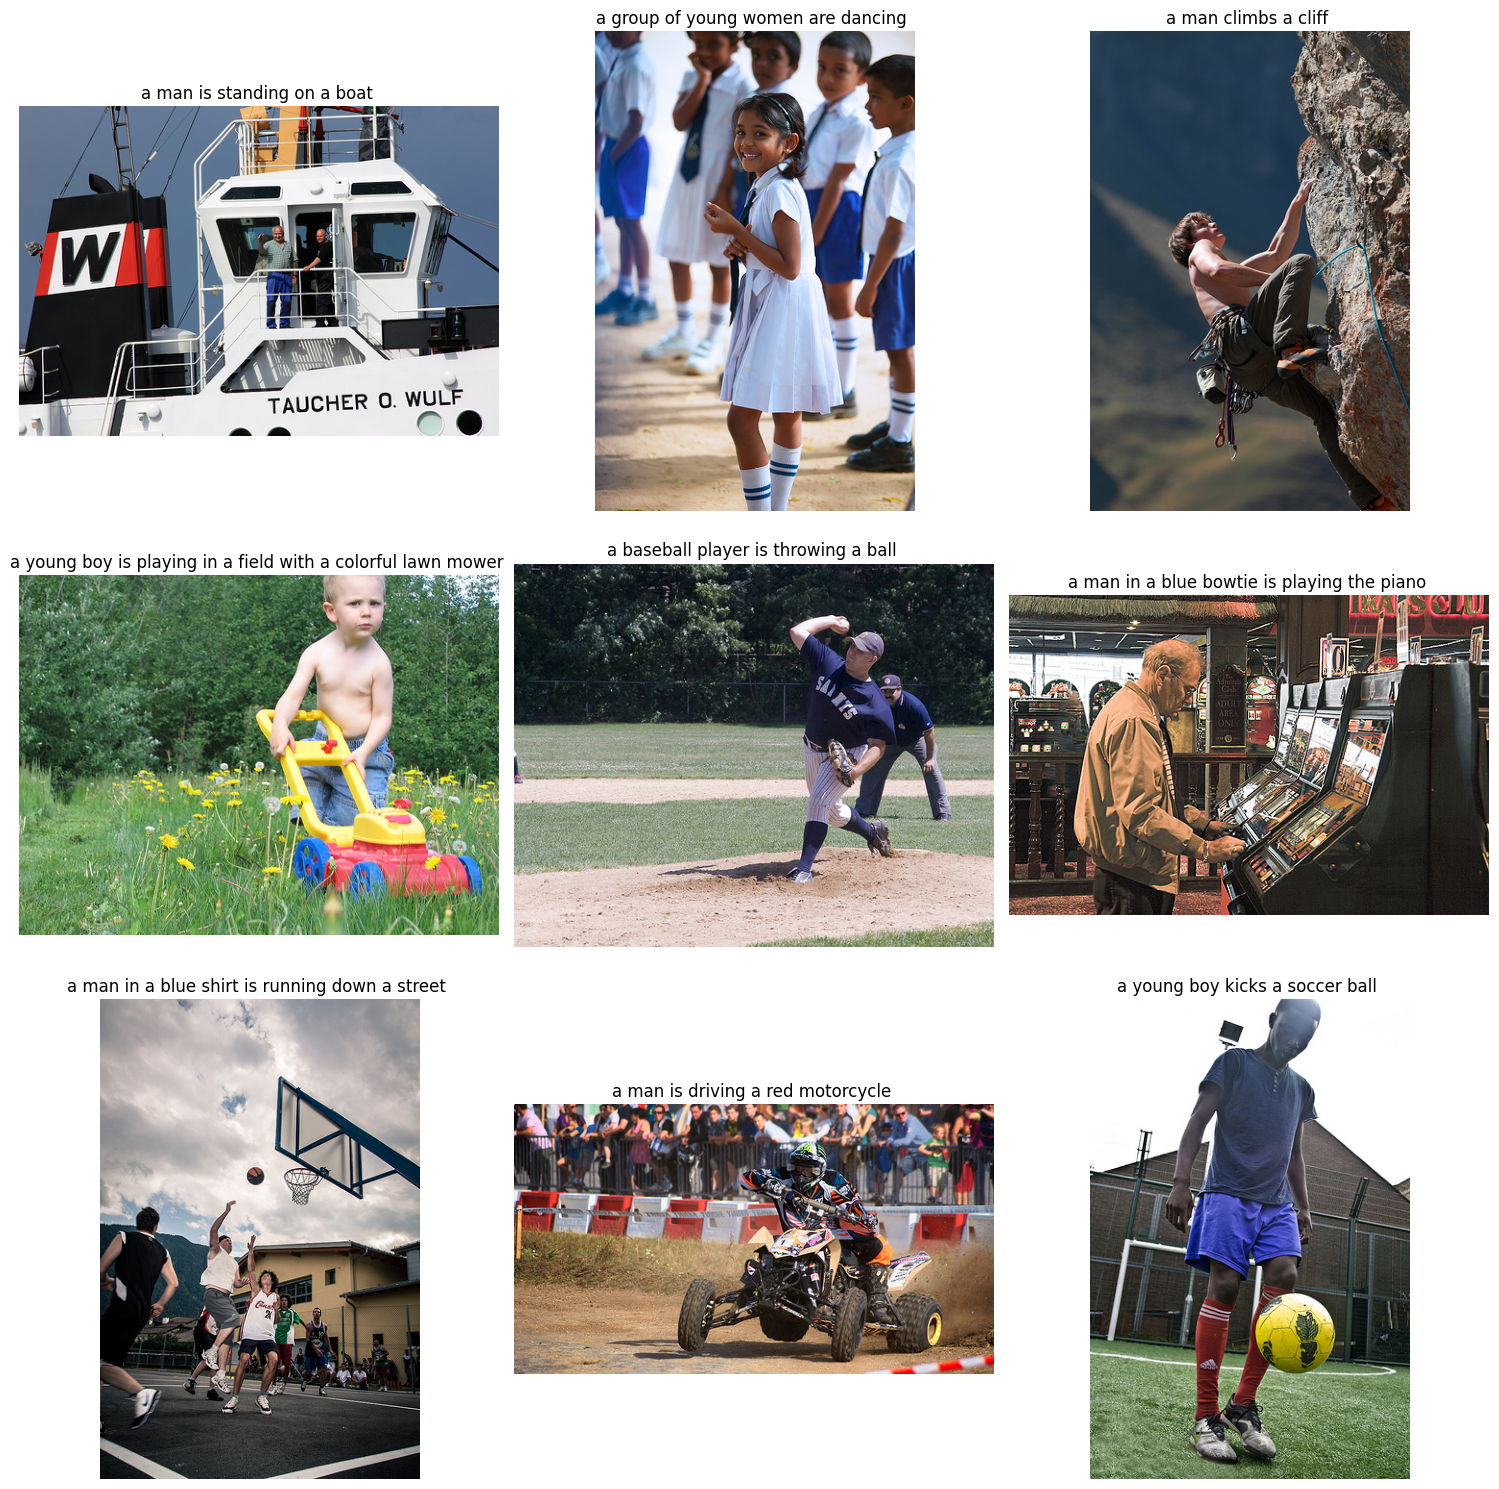

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import random

# Create a figure with 3x3 subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))


for i in range(9):
    
    image_path = val_image_paths[random.randint(0, len(val_image_paths))]
    
    test_image = preprocess_image(image_path)
    test_image = tf.expand_dims(test_image, axis=0)

    caption = generate_caption(test_image)
    
    # Load the image
    img = Image.open(image_path)
    
    # Determine the position in the grid
    row = i // 3
    col = i % 3
    
    # Display the image in the subplot
    axes[row, col].imshow(img)
    axes[row, col].axis('off')  # Turn off the axis
    
    # Set the caption below the image
    axes[row, col].set_title(caption, fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


## Testing with a custom_image apart from the validation set

This ensures our model can predict images apart from the validation_set, as both training_data and validation_data came from same data distribution

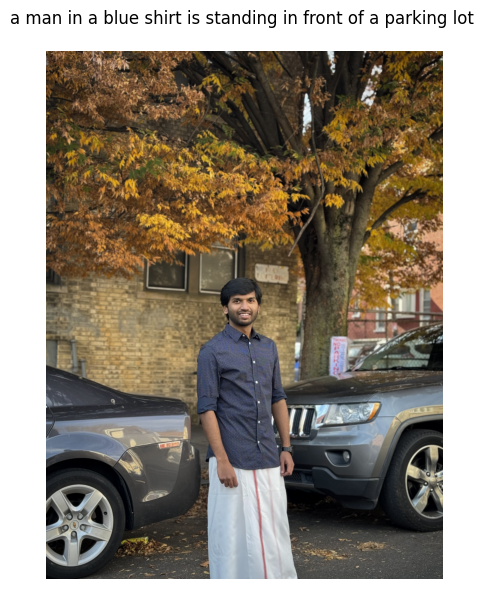

In [60]:
image_path = 'IMG_0322.jpg'
test_image = preprocess_image(image_path)
test_image = tf.expand_dims(test_image, axis=0)
caption = generate_caption(test_image)

img = Image.open(image_path)

fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(img)
ax.axis('off')

ax.set_title(caption, fontsize=12, pad=20)

plt.tight_layout()
plt.show()
